In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

base_path = '/content/drive/My Drive/combined1/'

# The code from MakeDataset.py to load the data
# This script reads the data from the Combined folder and creates the dataset.
folders = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]
classes = {"WALKING": 1, "WALKING_UPSTAIRS": 2, "WALKING_DOWNSTAIRS": 3, "SITTING": 4, "STANDING": 5, "LAYING": 6}
time_window = 10  # in seconds
samples_per_second = 50
offset = 100

X = []
y = []

# Load training data
dataset_dir = os.path.join(base_path, "Combined", "Train")
for folder in folders:
    files = os.listdir(os.path.join(dataset_dir, folder))
    for file in files:
        df = pd.read_csv(os.path.join(dataset_dir, folder, file), sep=",", header=0)
        df = df[offset:offset + time_window * samples_per_second]
        X.append(df.values)
        y.append(classes[folder])

# Load testing data
dataset_dir = os.path.join(base_path, "Combined", "Test")
for folder in folders:
    files = os.listdir(os.path.join(dataset_dir, folder))
    for file in files:
        df = pd.read_csv(os.path.join(dataset_dir, folder, file), sep=",", header=0)
        df = df[offset:offset + time_window * samples_per_second]
        X.append(df.values)
        y.append(classes[folder])

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4, stratify=y)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Data loaded successfully")

# Map the numerical labels to activity names for plotting
activities = {
    1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING', 5: 'STANDING', 6: 'LAYING'
}

Training data shape: (126, 500, 3)
Testing data shape: (54, 500, 3)
Data loaded successfully


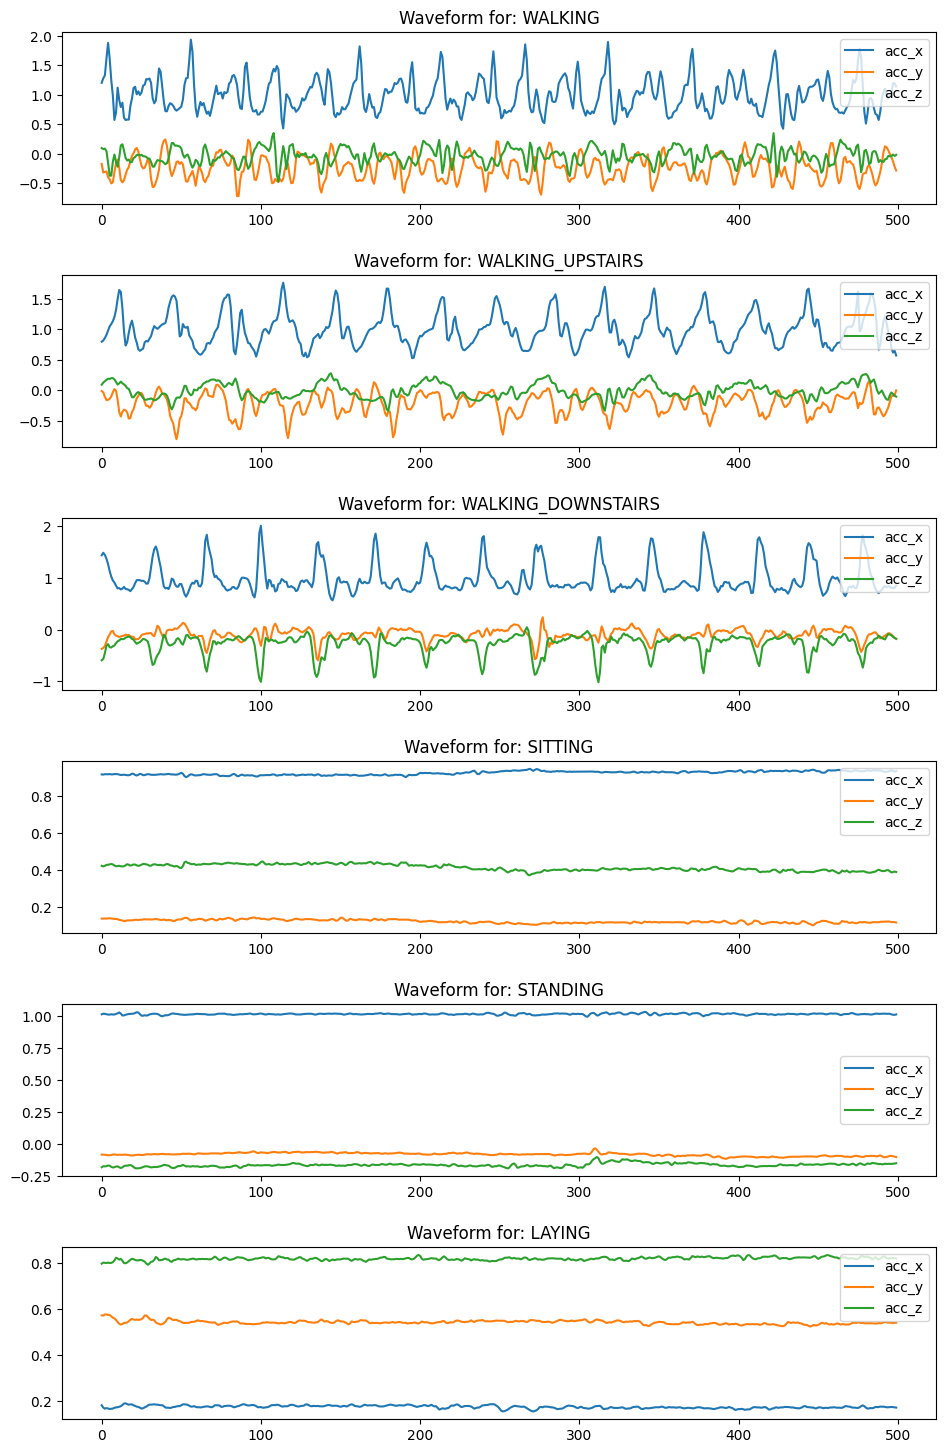

Analysis: Dynamic activities show periodic oscillations with higher amplitudes, while static activities have flatter waveforms. This suggests the data can be used for classification.


In [ ]:
# Q1: Plot the waveform for one sample data from each activity class.

fig, axes = plt.subplots(6, 1, figsize=(10, 15))
fig.tight_layout(pad=3.0)

for i, activity_label in activities.items():
    sample_idx = np.where(y_train == i)[0][0]
    sample_data = X_train[sample_idx]

    axes[i-1].plot(sample_data[:, 0], label='acc_x')
    axes[i-1].plot(sample_data[:, 1], label='acc_y')
    axes[i-1].plot(sample_data[:, 2], label='acc_z')
    axes[i-1].set_title(f"Waveform for: {activity_label}")
    axes[i-1].legend()

plt.show()

print("Analysis: Dynamic activities show periodic oscillations with higher amplitudes, while static activities have flatter waveforms. This suggests the data can be used for classification.")

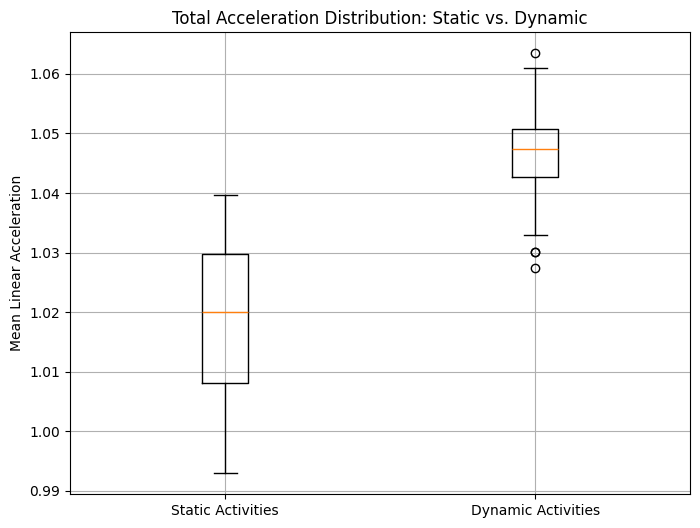

Mean acceleration for static activities: 1.0183
Mean acceleration for dynamic activities: 1.0464
Justification: A simple threshold value is enough to differentiate if the activity is static or dynamic


In [ ]:
# Q2: Do we need a machine learning model to differentiate static and dynamic activities?

static_activities = [4, 5, 6]
dynamic_activities = [1, 2, 3]

# Calculate total linear acceleration for each sample
total_acc_sq = (X_train[:, :, 0]**2 + X_train[:, :, 1]**2 + X_train[:, :, 2]**2)

# Calculate the mean total acceleration per sample
mean_total_acc = np.mean(np.sqrt(total_acc_sq), axis=1)

# Group by activity type
static_acc = mean_total_acc[np.isin(y_train, static_activities)]
dynamic_acc = mean_total_acc[np.isin(y_train, dynamic_activities)]

plt.figure(figsize=(8, 6))
plt.boxplot([static_acc, dynamic_acc], labels=['Static Activities', 'Dynamic Activities'])
plt.title('Total Acceleration Distribution: Static vs. Dynamic')
plt.ylabel('Mean Linear Acceleration')
plt.grid(True)
plt.show()


print(f"Mean acceleration for static activities: {np.mean(static_acc):.4f}")
print(f"Mean acceleration for dynamic activities: {np.mean(dynamic_acc):.4f}")
print("Justification: A simple threshold value is enough to differentiate if the activity is static or dynamic")

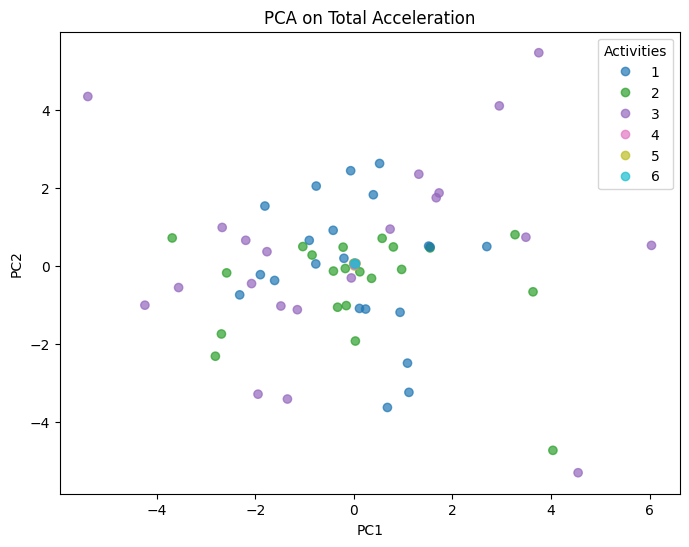

In [ ]:
# Q3: Visualize the data using PCA.

# 1. PCA on Total Acceleration
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Compute total acceleration magnitude
total_acc = np.sqrt(X_train[:,:,0]**2 + X_train[:,:,1]**2 + X_train[:,:,2]**2)

# Flatten each signal (500 points) into one vector per sample
total_acc_flat = total_acc.reshape(total_acc.shape[0], -1)

#Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(total_acc_flat)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train, cmap="tab10", alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Activities")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA on Total Acceleration")
plt.show()


In [ ]:
!pip install tsfel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 707.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.1 MB/s eta 0:00:00


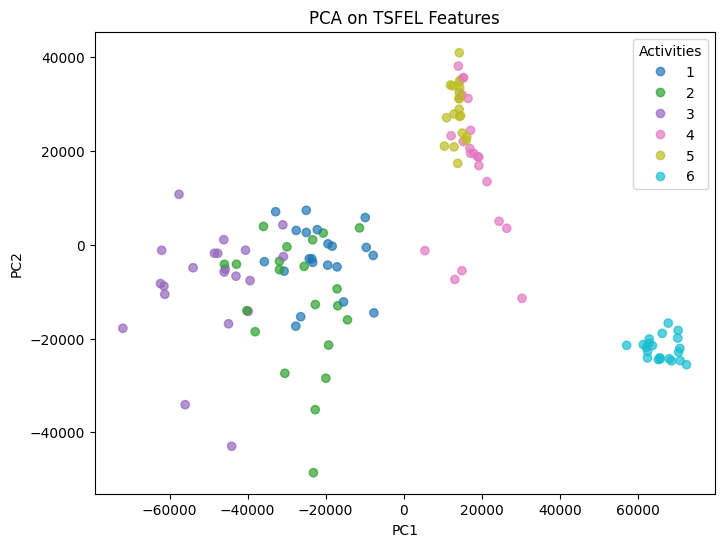

In [ ]:
# Q3
# 2. PCA on tsfel
import pandas as pd
import tsfel

# Load TSFEL config
cfg = tsfel.get_features_by_domain()

# --- Step 1: Extract features for all samples ---
features_list = []
for i in range(X_train.shape[0]):   # loop over samples
    df = pd.DataFrame({
        "acc_x": X_train[i,:,0],
        "acc_y": X_train[i,:,1],
        "acc_z": X_train[i,:,2]
    })
    feats = tsfel.time_series_features_extractor(cfg, df, fs=50, verbose=0)
    features_list.append(feats)

# Combine into one DataFrame
features_df = pd.concat(features_list, ignore_index=True)
features_df["label"] = y_train
X_feats = features_df.drop(columns=["label"])
y_feats = features_df["label"]

# PCA
pca = PCA(n_components=2)
X_pca_feats = pca.fit_transform(X_feats)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_feats[:,0], X_pca_feats[:,1], c=y_feats, cmap="tab10", alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Activities")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA on TSFEL Features")
plt.show()



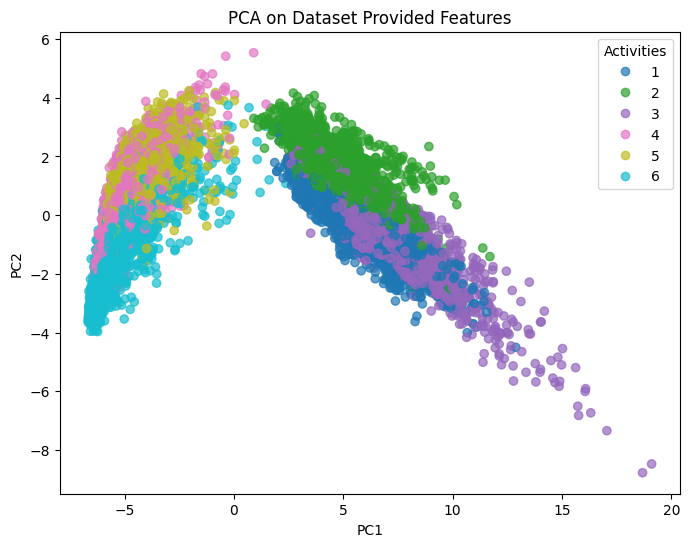

In [ ]:
# Q3
# 3.PCA on dataset provided features
import pandas as pd
import numpy as np

data_path = "/content/drive/MyDrive/combined1/UCI HAR Dataset/"

# Load training features and labels
X_train_dataset = pd.read_csv(data_path + "train/X_train.txt", delim_whitespace=True, header=None)
y_train_dataset = pd.read_csv(data_path + "train/y_train.txt", delim_whitespace=True, header=None)

# Load test features and labels
X_test_dataset = pd.read_csv(data_path + "test/X_test.txt", delim_whitespace=True, header=None)
y_test_dataset = pd.read_csv(data_path + "test/y_test.txt", delim_whitespace=True, header=None)

# Combine train and test
X_dataset = pd.concat([X_train_dataset, X_test_dataset], axis=0)
y_dataset = pd.concat([y_train_dataset, y_test_dataset], axis=0).values.ravel()


pca = PCA(n_components=2)
X_pca_dataset = pca.fit_transform(X_dataset)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca_dataset[:,0], X_pca_dataset[:,1], c=y_dataset, cmap="tab10", alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Activities")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA on Dataset Provided Features")
plt.show()

Q3 4.

Features provided by the dataset are more informative as it shows clearer patterns and clusters. The features provided by the dataset capture specific aspects of the activities being analyzed that is more relevant to distinguishing between different classes of activities.

In [ ]:
# Q4
features_path = "/content/drive/MyDrive/combined1/UCI HAR Dataset/UCI HAR Dataset/features.txt"
with open(features_path, 'r') as f:
    uci_feature_names = [line.strip().split()[1] for line in f.readlines()]

X_train_path = "/content/drive/MyDrive/combined1/UCI HAR Dataset/train/X_train.txt"
y_train_path = "/content/drive/MyDrive/combined1/UCI HAR Dataset/train/y_train.txt"
with open(features_path, 'r') as f:
    uci_feature_names = [line.strip().split()[1] for line in f.readlines()]

X_trainn = pd.read_csv(X_train_path, sep='\s+', header=None)
X_trainn.columns = uci_feature_names
n=len(X_feats.columns)
# Align number of samples
X_train_subset = X_trainn.iloc[:X_feats.shape[0], :]

combined_features = np.hstack((X_feats.values, X_train_subset.values))

combined_feature_names = list(X_feats.columns) + [f"UCI_{name}" for name in uci_feature_names[:X_train_subset.shape[1]]]

combined_df = pd.DataFrame(combined_features, columns=combined_feature_names)

standardized_df = (combined_df - combined_df.mean()) / combined_df.std()

# Correlation matrix
corr_matrix = standardized_df.corr()

threshold = 0.9
high_corr_pairs = []
cols = corr_matrix.columns

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((cols[i], cols[j], corr_matrix.iloc[i, j]))

print("Highly correlated pairs of features (|corr| > 0.9):")
for f1, f2, corr in high_corr_pairs:
    print(f"{f1}  <-->  {f2}   corr = {corr:.2f}")


Highly correlated pairs of features (|corr| > 0.9):
acc_x_Absolute energy  <-->  acc_x_Area under the curve   corr = 0.98
acc_x_Absolute energy  <-->  acc_x_Average power   corr = 1.00
acc_x_Absolute energy  <-->  acc_x_ECDF Percentile_1   corr = 0.97
acc_x_Absolute energy  <-->  acc_x_Mean   corr = 0.98
acc_x_Absolute energy  <-->  acc_x_Median   corr = 0.95
acc_x_Absolute energy  <-->  acc_x_Root mean square   corr = 0.99
acc_x_Absolute energy  <-->  acc_x_Wavelet absolute mean_1.39Hz   corr = 0.97
acc_x_Absolute energy  <-->  acc_x_Wavelet absolute mean_1.56Hz   corr = 0.97
acc_x_Absolute energy  <-->  acc_x_Wavelet absolute mean_1.79Hz   corr = 0.96
acc_x_Absolute energy  <-->  acc_x_Wavelet absolute mean_12.5Hz   corr = 0.93
acc_x_Absolute energy  <-->  acc_x_Wavelet absolute mean_2.08Hz   corr = 0.95
acc_x_Absolute energy  <-->  acc_x_Wavelet absolute mean_2.5Hz   corr = 0.94
acc_x_Absolute energy  <-->  acc_x_Wavelet absolute mean_3.12Hz   corr = 0.94
acc_x_Absolute energy  <-->

Q4

The correlation analysis shows that several TSFEL features are highly correlated (>0.9) with the UCI HAR dataset features. This indicates that many of the features are redundant, as they capture the same statistical properties of the accelerometer signals,while if negative it inverse relation which also can be calculated if one of the feature is given. For example, TSFEL mean/variance features align closely with UCI’s mean and standard deviation features. Therefore, using both sets together would introduce redundancy without significantly improving model performance. A reduced feature set (removing highly correlated features) would likely be sufficient and more efficient.